# Computing Lyapunov exponents
This script computes the Lyapunov exponents of the Lorenz system without knowing the Jacobian matrix.

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import math as math
from scipy import integrate
from scipy.linalg import expm
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks


## Simulating the system

In [2]:
#parameters of the system
rho = 28
sigma = 10
beta =8/3

#Initial condition
state0 = np.array([-8, -8, 27])

def difeq(data,t):
    '''System of differential eqautions'''
    x,y,z=data
    xp=sigma*(y-x)
    yp=x*(rho-z)-y
    zp=x*y-beta*z
    return [xp,yp,zp]


In [3]:
dt=0.01
T=10000
discard_t = 100
T_total = T+discard_t
t=np.arange(0,T_total,dt)
X=integrate.odeint(difeq,state0,t)[int(discard_t/dt):]
N=len(X)


## Determining the average distance after one orbit
Using the methods explained in "Capturing the continuous complexity of behaviour in Caenorhabditis elegans", one finds the average distance of phase space points after a given number of recurrences.

In [4]:
#Maximal orbit length
tmax=100
#Number of considered recurrences
rmax=100
#Point where we compute the average distance
t0 = 200

eps_r_t = np.zeros((rmax,tmax))

for i in range(1,tmax):
    tp = np.linalg.norm(X[t0:-i]-X[t0+i:],axis=1)
    tp = np.sort(tp)
    eps_r_t[:,i] = tp[:rmax]

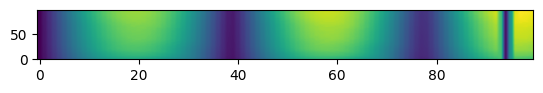

In [17]:
plt.imshow(eps_r_t,aspect=1e-1,origin='lower')
plt.show()

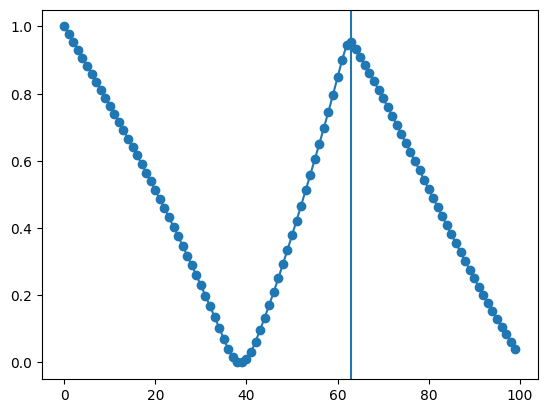

63


In [5]:
def norm2one(x):
    ma=np.max(x,axis=0);
    mi=np.min(x,axis=0);
    return (x-mi)/(ma-mi)

#Distance averaged over recurrences
eps_t = np.mean(eps_r_t,axis=0)

#Finding minimal distances --> Periodic orbits
peaks, _ = find_peaks(norm2one(-eps_t), prominence=.01)
plt.plot(np.arange(tmax),norm2one(-eps_t),marker='o')
plt.axvline(peaks[0])
plt.show()
print(peaks[0])

In [7]:
#Choosing the distance of one of the recurrences
eps_r_t[:,peaks[0]][:5]
epsilon = eps_r_t[:,peaks[0]][3]
print(epsilon)

0.24100210113541634


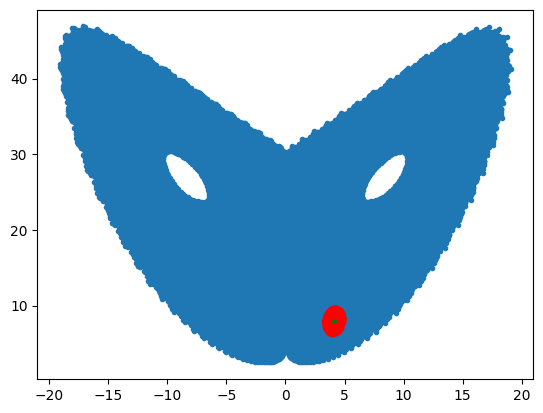

In [8]:
#Check that we have enough points
small_weight_threshold=1e-3
point=t0

#Distance to the considered point
dist = np.linalg.norm(X-X[point],axis=1)
    
#Weight for each point
wts = np.exp(-dist/epsilon)
wts[point-10:point+10]=0
sel = np.ones(len(X),dtype=bool)

#Excluding points with small weight
sel[wts/wts.max()<small_weight_threshold] = False

plt.figure()
plt.plot(X[:,0],X[:,2],'.')
plt.plot(X[sel,0],X[sel,2],'r.')
plt.plot(X[point,0],X[point,2],'g.',markersize=5)

In [9]:
def QR_decomp(Matrix):
    '''This fct does QR decomposition of the input matrix 
    and makes sure that the diagonal element of R are positive
    (This is conventional as the QR decomposition is not unique)'''
    Qmat,Rmat = np.linalg.qr(Matrix)
    Rdiag=np.diag(Rmat)
    for k in range(len(Rdiag)):
        if Rdiag[k]<0:
            Rmat[k,:]=-Rmat[k,:]
            Qmat[:,k]=-Qmat[:,k]
    return Qmat,Rmat

def estimate_lyap_exp(Ms,L=1,N=1000):
    #Dimension of state space
    dim = Ms[0].shape[1]
    #Global flow
    Flow = np.identity(dim)
    Qhat = np.identity(dim)
    #local exp(Jacobian*dt) at point data[0]
    M=Ms[0]
    #Using Q,R decomposition
    Q, R = QR_decomp(M)
    #Storing the Lyapunov exponents
    exponents = np.zeros(len(R))
    exps = []
    for i in range(1,N):
        M = Ms[i]
        Flow = np.dot(M,Flow)
        #Compute Lyapunov exponent
        if i % L == 0:
            Flow = np.linalg.multi_dot([Qhat.T, Flow, Qhat])
            Q, R = QR_decomp(Flow)
            exponents=exponents+np.log(np.diag(R))
            #Compute new Qhat
            Qhat = np.dot(Qhat,Q)
            #Reset the flow
            Flow = np.identity(dim)
            exps.append(exponents/(i*dt))
    return exps


def estimate_discrete_jac(X,epsilon,trange,small_weight_threshold=1e-5,T1=1):
    Ms=np.zeros((len(trange),X.shape[1],X.shape[1]))
    #Initial state
    XX=X[:-T1,:]
    #Evolved state
    Xn=X[T1:,:]
    #Computing all the exp(J*dt) matrices
    for ipred in trange:
        sel = np.ones(len(XX),dtype=bool)
        #Exclude the point where we estimate
        sel[ipred] = False
        dist = np.linalg.norm(XX-XX[ipred],axis=1)
        wts = np.exp(-dist/epsilon)
        #Excluding the nearest neighbours from the same recurrence
        if ipred<10:
            wts[:ipred]=0
        elif len(wts)-ipred<10:
            wts[-ipred:]=0
        else:
            wts[ipred-10:ipred+10]=0
            
        #Excluding points with small weight
        sel[wts/wts.max()<small_weight_threshold] = False
        wts = wts[sel]
        #Stacking column of ones to have additional parameter in regression
        z=np.hstack([np.ones(sel.sum()).reshape(-1,1),XX[sel]])
        
        if sel.sum()<4:
            print("Very few points (",(sel.sum()),")", " at step : ",ipred, " decrease small_weight_treshold?")
            
        zw = np.vstack([z[:,m]*wts for m in range(z.shape[1])]).T
        znw =  np.vstack([Xn[sel,m]*wts for m in range(Xn.shape[1])]).T
        #Doint the linear regression
        A = np.linalg.pinv(zw).dot(znw)
        #Getting rid of constants
        Ms[ipred] = A[1:].T
    return Ms


def J_explicit(point):
    """Explicit Jacobian for Lorenz system at point tseries[j]"""
    x,y,z=point
    J=np.array([[-sigma,sigma,0],[rho-z,-1,-x],[y,x,-beta]])
    return J

## Optimizing epsilon
As we know that one of the exponents should be zero, we can try to vary epsilon in order to find an exponent as close to zero as possible.

In [ ]:
trange = np.arange(0,3000)
#Perturbation of epsilon
epsvalues=np.linspace(epsilon*2,epsilon*2.4,10)
zeroexp=[]
for eps in epsvalues:
    Ms = estimate_discrete_jac(X,eps,trange)
    exps = estimate_lyap_exp(Ms,N=len(Ms))
    print(np.mean(exps[-40:],axis=0))
    zeroexp.append(abs(np.mean(exps[-40:],axis=0)).min())
mi=min(zeroexp)
pos=zeroexp.index(mi)
print(epsvalues[pos])

plt.figure()
plt.plot(epsvalues,zeroexp,'.')
plt.show()

## Computing the Lyapunov exponents

In [22]:
epsilonmin=0.546271429240277
trange = np.arange(0,3000)
#Getting the exp(J*dt) matrices 
Ms = estimate_discrete_jac(X,epsilonmin,trange)

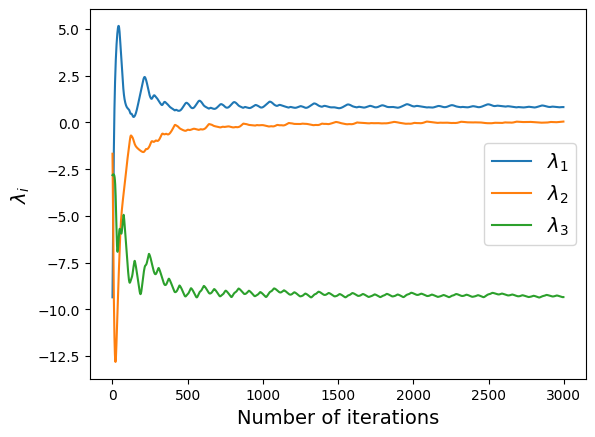

Average over last 1000 values :  [ 8.50237833e-01 -4.06265988e-04 -9.26149478e+00]
Error over last 1000 values :  [0.03743444 0.02299525 0.05426613]


In [24]:
#Computing the Lyapunov exponents
exps = estimate_lyap_exp(Ms,N=len(Ms))

fig=plt.figure()
plt.plot(exps,label=["$\lambda_1$","$\lambda_2$","$\lambda_3$"])
plt.legend(prop={'size': 14})
plt.xlabel("Number of iterations",fontsize=14)
plt.ylabel("$\lambda_i$",fontsize=14)

fig.savefig('LyapConv_Lorenz.png', format='png', dpi=1200)
plt.show()

print("Average over last 1000 values : ",np.mean(exps[-1000:],axis=0))
print("Error over last 1000 values : ",np.std(exps[-1000:],axis=0))